## Exercise 1

In this exercise, you will use PCA to reduce the MINST data set and visualize the approximation.

### Step 1: Load the data

You don't actually have to do anything here!  Just run the code...

In [1]:
# @SHOW
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load MNIST data
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"].values, mnist["target"].astype(int).values

# Sample the dataset to speed up computation (Optional)
X, y = X[:7000], y[:7000]

# Split the dataset
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Step 2: Use PCA to reduce the data set


Visualize your result with a 2d scatter plot, colored by class (the digit identitiy)

Explained variance by 2 PCs: 0.176


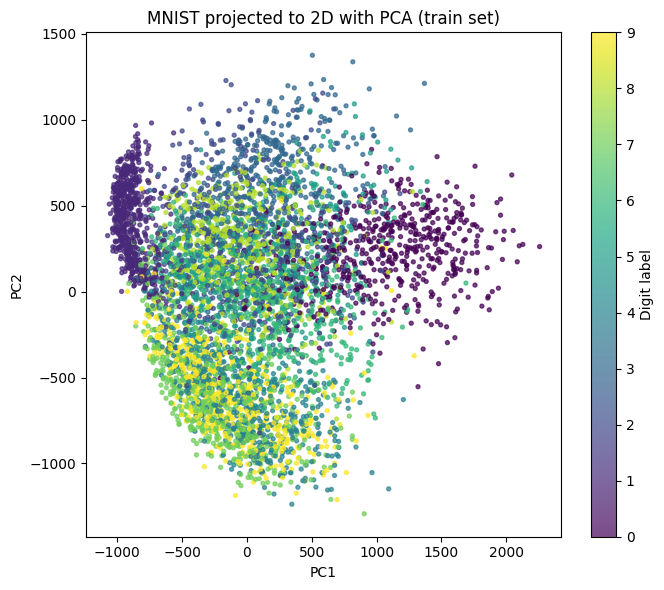

In [3]:
# Your code here


pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_mnist_train)
X_test_pca  = pca.transform(X_mnist_test)

print(f"Explained variance by 2 PCs: {pca.explained_variance_ratio_.sum():.3f}")

plt.figure(figsize=(7,6))
sc = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                 c=y_mnist_train, s=8, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MNIST projected to 2D with PCA (train set)")
cbar = plt.colorbar(sc, ticks=range(10))
cbar.set_label("Digit label")
plt.tight_layout()
plt.show()


#### Step 3: Scree plot

Calculate and visualize a scree plot for the first 40 component.  The y-axis should be 'percent of variance explained'.

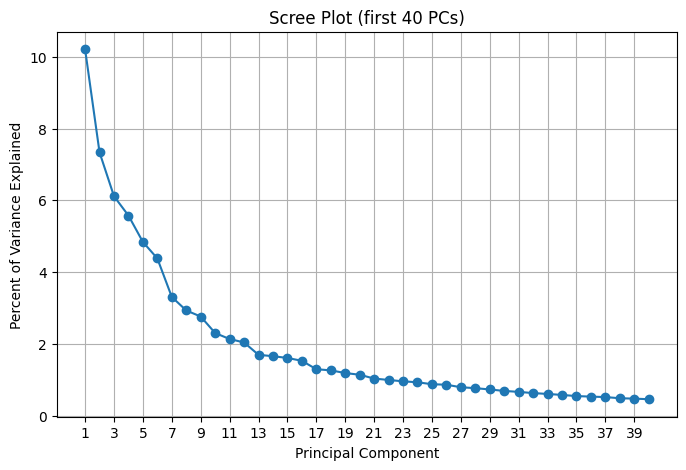

In [4]:
# Your code here

pca_full = PCA(n_components=40, random_state=42)
pca_full.fit(X_mnist_train)

explained_variance = pca_full.explained_variance_ratio_ * 100

plt.figure(figsize=(8,5))
plt.plot(range(1, 41), explained_variance, marker='o')
plt.title("Scree Plot (first 40 PCs)")
plt.xlabel("Principal Component")
plt.ylabel("Percent of Variance Explained")
plt.xticks(range(1, 41, 2))
plt.grid(True)
plt.show()


#### Step 4: Select the number of components


Calculate the number of components required to explain 95% of the variance

Number of components to explain 95% variance: 148


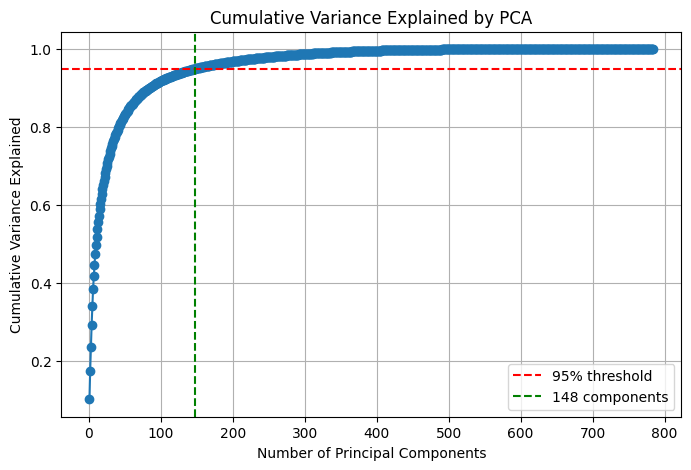

In [5]:
# Your code here

pca_all = PCA().fit(X_mnist_train)

cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components to explain 95% variance: {n_components_95}")

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.axvline(x=n_components_95, color='g', linestyle='--',
            label=f'{n_components_95} components')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by PCA")
plt.legend()
plt.grid(True)
plt.show()


### Step 5: Visualize a digit in the reduced dimensionality space


I've provided a function for visualizing a digit. Figure out how to visualize the same digit using the number of dimensions identified in Step 4.

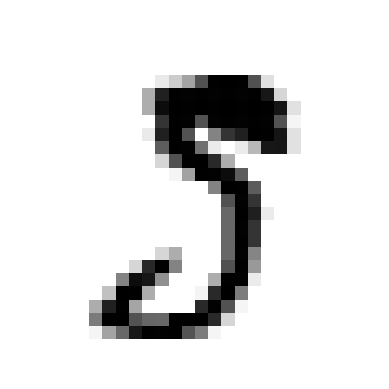

In [7]:
# @SHOW
def plot_mnist_digit(digit):
    """Plot a single MNIST digit.

    Parameters:
    digit (numpy array): A flattened 1D numpy array of length 784.

    """
    # Reshape the flattened digit to 28x28 image
    digit_image = digit.reshape(28, 28)
    
    plt.imshow(digit_image, cmap='binary')
    plt.axis("off")
    plt.show()

plot_mnist_digit(X_mnist_train[0])

Using 148 components
Label of chosen digit: 3
Original digit:


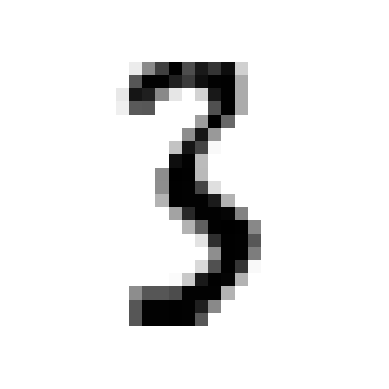

Reconstructed digit:


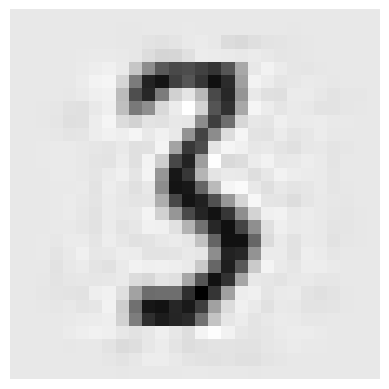

In [8]:
# Your code here

try:
    n_components_95
except NameError:
    pca_all = PCA().fit(X_mnist_train)
    cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Using {n_components_95} components")

pca_95 = PCA(n_components=n_components_95, random_state=42)
pca_95.fit(X_mnist_train)

digit_index = 0   
original_digit = X_mnist_test[digit_index]

z = pca_95.transform([original_digit])         
reconstructed_digit = pca_95.inverse_transform(z)[0]  

print(f"Label of chosen digit: {y_mnist_test[digit_index]}")

print("Original digit:")
plot_mnist_digit(original_digit)

print("Reconstructed digit:")
plot_mnist_digit(reconstructed_digit)


### Step 6: Use dimensionality reduction to preprocess data


See how a KNN Classifier works with and without dimensionality reduction. Preserve 80% of the variance.

In [9]:
# Your code here

import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def scale01(X):
    X = X.astype(np.float32, copy=False)
    mx = X.max()
    return X / 255.0 if mx > 1.5 else X  

Xtr = scale01(X_mnist_train.copy())
Xte = scale01(X_mnist_test.copy())

pca_all = PCA().fit(Xtr)
cumvar = np.cumsum(pca_all.explained_variance_ratio_)
n_components_80 = int(np.argmax(cumvar >= 0.80) + 1)
print(f"Components for ≥80% variance: {n_components_80}")

pca_80 = PCA(n_components=n_components_80, random_state=42).fit(Xtr)
Xtr_pca = pca_80.transform(Xtr)
Xte_pca = pca_80.transform(Xte)

t0 = time.perf_counter()
knn_raw = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_raw.fit(Xtr, y_mnist_train)
yhat_raw = knn_raw.predict(Xte)
t_raw = time.perf_counter() - t0
acc_raw = accuracy_score(y_mnist_test, yhat_raw)

t1 = time.perf_counter()
knn_pca = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_pca.fit(Xtr_pca, y_mnist_train)
yhat_pca = knn_pca.predict(Xte_pca)
t_pca = time.perf_counter() - t1
acc_pca = accuracy_score(y_mnist_test, yhat_pca)

print(f"Raw dims: {Xtr.shape[1]}  ->  PCA dims: {n_components_80}")
print(f"KNN (raw): acc={acc_raw:.4f}, time={t_raw:.2f}s")
print(f"KNN (PCA): acc={acc_pca:.4f}, time={t_pca:.2f}s")


Components for ≥80% variance: 42
Raw dims: 784  ->  PCA dims: 42
KNN (raw): acc=0.9429, time=2.60s
KNN (PCA): acc=0.9457, time=0.02s


## Exercise 2
<!-- @q -->
1. Try using t-SNE to visualize the MNIST data above.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.158189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.891205
[t-SNE] KL divergence after 1000 iterations: 1.289619


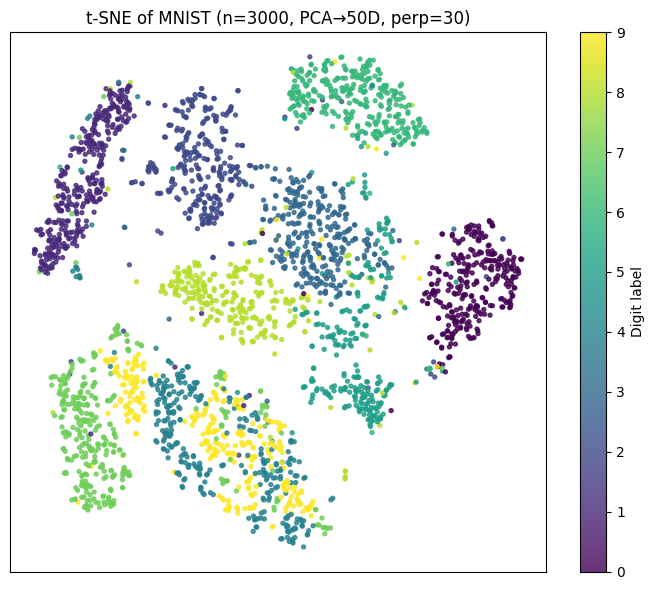

In [12]:
# Your code here

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import inspect


n_samples   = 3000     
pca_dims    = 50       
perplexity  = 30       
n_iter      = 1000     
random_seed = 42


if "X_mnist_train" in globals() and "X_mnist_test" in globals():
    X_all = np.vstack([X_mnist_train, X_mnist_test])
    y_all = np.hstack([y_mnist_train, y_mnist_test])
else:
    X_all, y_all = X, y

rng = np.random.default_rng(random_seed)
idx = rng.choice(len(X_all), size=min(n_samples, len(X_all)), replace=False)
X_sub = X_all[idx].astype(np.float32, copy=False)
y_sub = y_all[idx]


if X_sub.max() > 1.5:
    X_sub = X_sub / 255.0

pca_k = min(pca_dims, X_sub.shape[1])
X_pca = PCA(n_components=pca_k, random_state=random_seed).fit_transform(X_sub)

tsne_kwargs = dict(
    n_components=2,
    perplexity=min(perplexity, max(5, len(X_pca)//10)),
    init="pca",
    random_state=random_seed,
    verbose=1,
)
sig = inspect.signature(TSNE.__init__).parameters

tsne_kwargs["learning_rate"] = 200 if "learning_rate" in sig and sig["learning_rate"].default is inspect._empty else "auto"

if "n_iter" in sig:
    tsne_kwargs["n_iter"] = n_iter
elif "max_iter" in sig:
    tsne_kwargs["max_iter"] = n_iter

tsne = TSNE(**tsne_kwargs)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(7, 6))
sc = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, s=8, alpha=0.8)
plt.title(f"t-SNE of MNIST (n={len(X_tsne)}, PCA→{pca_k}D, perp={perplexity})")
cbar = plt.colorbar(sc, ticks=range(10)); cbar.set_label("Digit label")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()


2. Try using a KNN classifier to predict the data with TSNE.  How does it perform?

In [13]:
# Your code here

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

if "X_tsne" not in globals():
    from sklearn.manifold import TSNE
    X_pca = PCA(n_components=50, random_state=42).fit_transform(X_mnist_train)
    tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=42)
    X_tsne = tsne.fit_transform(X_pca[:3000])   
    y_tsne = y_mnist_train[:3000]
else:
    y_tsne = y_sub

from sklearn.model_selection import train_test_split
X_tsne_train, X_tsne_test, y_tsne_train, y_tsne_test = train_test_split(
    X_tsne, y_tsne, test_size=0.2, random_state=42
)

knn_tsne = KNeighborsClassifier(n_neighbors=3)
knn_tsne.fit(X_tsne_train, y_tsne_train)
y_pred_tsne = knn_tsne.predict(X_tsne_test)

acc_tsne = accuracy_score(y_tsne_test, y_pred_tsne)
print(f"KNN accuracy on t-SNE (2D) embeddings: {acc_tsne:.4f}")


KNN accuracy on t-SNE (2D) embeddings: 0.9267


## Exercise 3

Try using UMAP to process the MNIST data.  Visualize the data first.

In [ ]:
# @SHOW
# You might need to install UMAP.  If so, uncomment the following lines and run them

# %pip install numpy==2.0
# %pip install umap-learn

E:\week-4-materials-akashkuteX\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


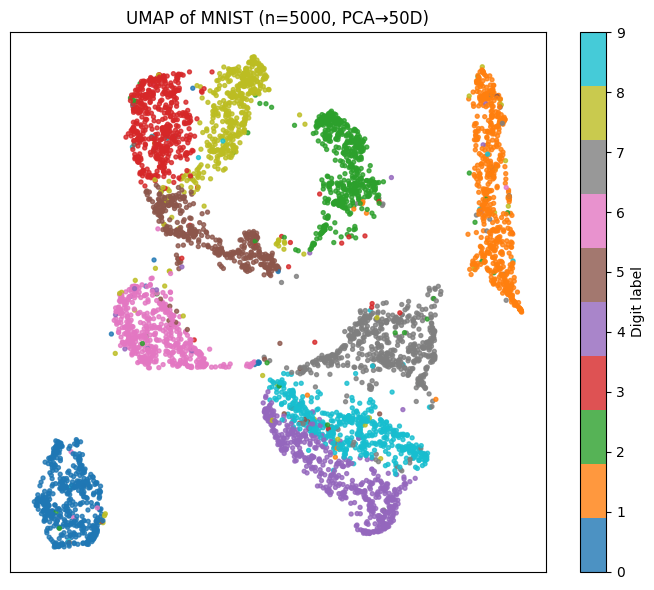

In [18]:
# Your code here


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap


n_samples   = 5000     
pca_dims    = 50       
random_seed = 42

if "X_mnist_train" in globals() and "X_mnist_test" in globals():
    X_all = np.vstack([X_mnist_train, X_mnist_test])
    y_all = np.hstack([y_mnist_train, y_mnist_test])
else:
    X_all, y_all = X, y

rng = np.random.default_rng(random_seed)
idx = rng.choice(len(X_all), size=min(n_samples, len(X_all)), replace=False)
X_sub = X_all[idx].astype(np.float32, copy=False)
y_sub = y_all[idx]

if X_sub.max() > 1.5:
    X_sub = X_sub / 255.0

pca_k = min(pca_dims, X_sub.shape[1])
X_pca = PCA(n_components=pca_k, random_state=random_seed).fit_transform(X_sub)

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=random_seed
)
X_umap = umap_model.fit_transform(X_pca)

plt.figure(figsize=(7,6))
sc = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_sub, s=8, alpha=0.8, cmap="tab10")
plt.title(f"UMAP of MNIST (n={len(X_umap)}, PCA→{pca_k}D)")
cbar = plt.colorbar(sc, ticks=range(10)); cbar.set_label("Digit label")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()


Now, calculate accuracy with KNN.

In [19]:
# Your code here

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


X_umap_train, X_umap_test, y_umap_train, y_umap_test = train_test_split(
    X_umap, y_sub, test_size=0.2, random_state=42
)

knn_umap = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_umap.fit(X_umap_train, y_umap_train)

y_pred_umap = knn_umap.predict(X_umap_test)
acc_umap = accuracy_score(y_umap_test, y_pred_umap)

print(f"KNN accuracy on UMAP (2D) embeddings: {acc_umap:.4f}")


KNN accuracy on UMAP (2D) embeddings: 0.9210


## Exercise 4

In the following, I've set up some sample data. Examine the relative performance of PCA and UMAP; for each, try gradually increasing the number of dimensions and examine the impact on KNN. You should also try different parameter settings for UMAP. Make sure to visualize your data after dimensionality reduction to understand what's going on!

Original Data Accuracy: 0.844


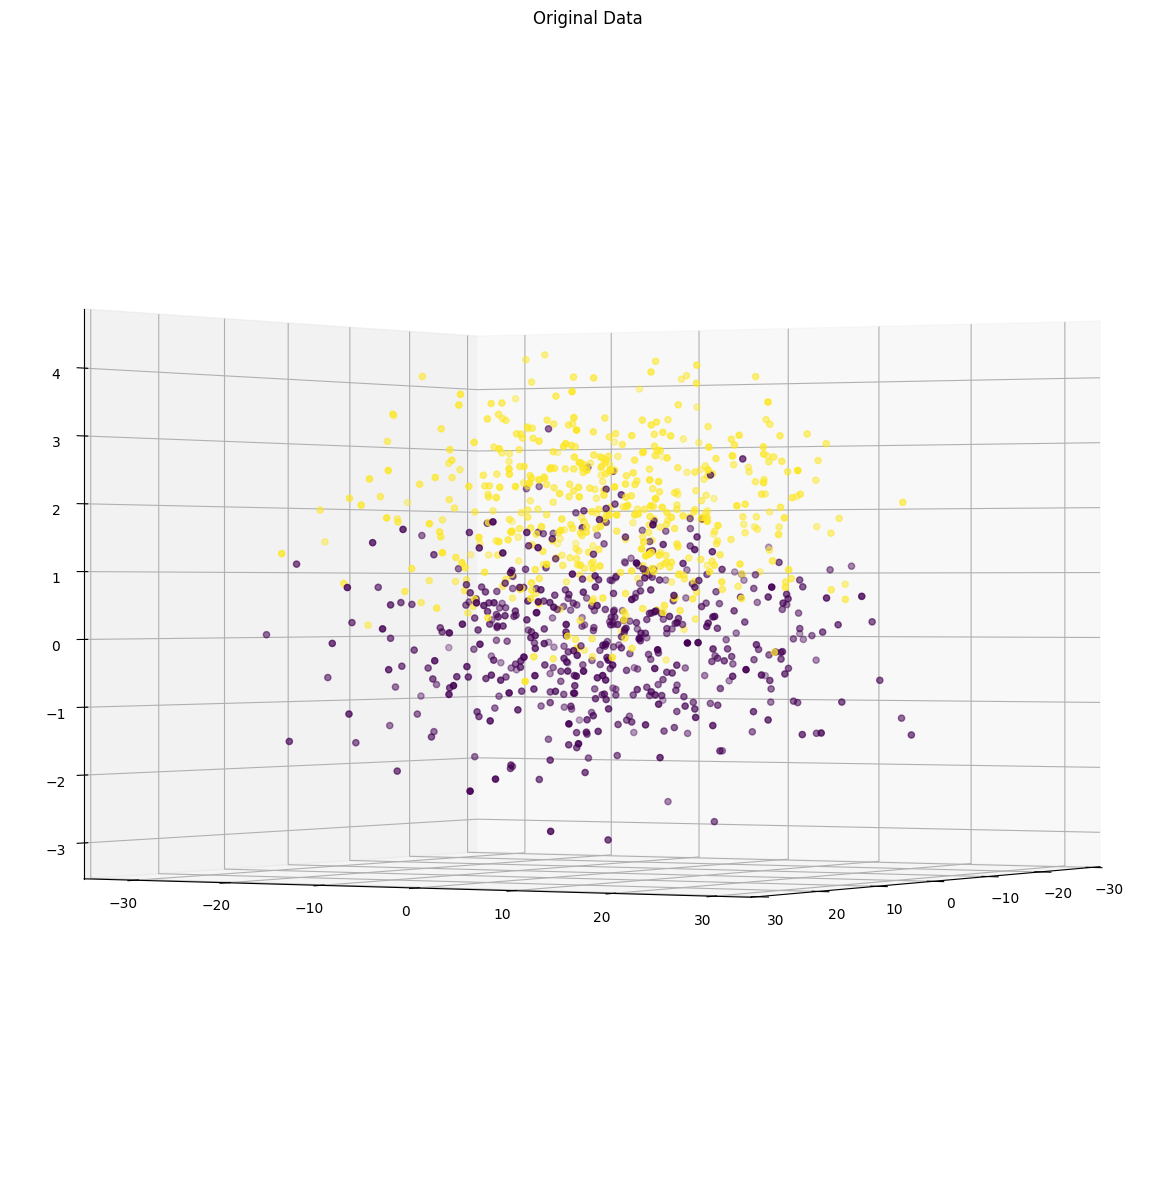

In [20]:
# @SHOW
# Generate synthetic data
np.random.seed(0)
n_points = 500

# Class 0
x0 = np.random.normal(loc=0, scale=10, size=n_points)
y0 = np.random.normal(loc=0, scale=10, size=n_points)
z0 = np.random.normal(loc=0, scale=1, size=n_points)

# Class 1
x1 = np.random.normal(loc=0, scale=10, size=n_points)
y1 = np.random.normal(loc=0, scale=10, size=n_points)
z1 = np.random.normal(loc=2, scale=1, size=n_points)

X = np.vstack((np.hstack((x0, x1)), np.hstack((y0, y1)), np.hstack((z0, z1)))).T
y = np.hstack((np.zeros(n_points), np.ones(n_points)))



# Train KNN on original data
knn = KNeighborsClassifier()
knn.fit(X, y)
y_pred = knn.predict(X)
print(f"Original Data Accuracy: {accuracy_score(y, y_pred)}")

# Create a new figure
fig = plt.figure(figsize=(15,15))

# Add 3D subplot
# The format is (rows, columns, plot_number)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=0, azim=30)

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis')
ax.set_title('Original Data')

plt.show()


In [21]:
# @SHOW
# Set up train and test, and examine predictions without dimensionality reduction

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Original Data Accuracy: {accuracy_score(y_test, y_pred)}")

Original Data Accuracy: 0.725


1. Try with PCA

PCA (2D) Accuracy: 0.495


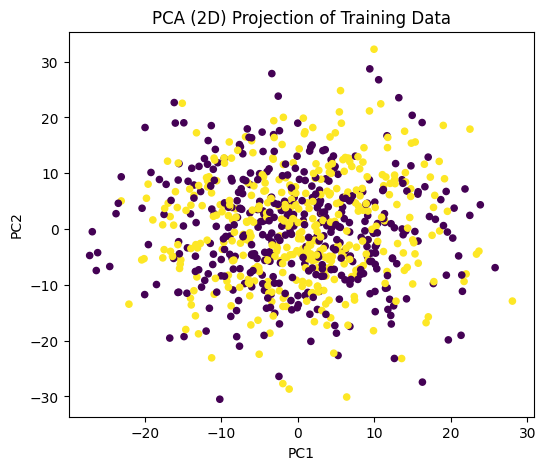

In [22]:
# Your code here
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

knn_pca = KNeighborsClassifier(n_neighbors=3)
knn_pca.fit(X_train_pca, y_train)
y_pred_pca = knn_pca.predict(X_test_pca)

print(f"PCA (2D) Accuracy: {accuracy_score(y_test, y_pred_pca):.3f}")

plt.figure(figsize=(6,5))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, cmap="viridis", s=20)
plt.title("PCA (2D) Projection of Training Data")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


2. Try with UMAP.

E:\week-4-materials-akashkuteX\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (2D) Accuracy: 0.545


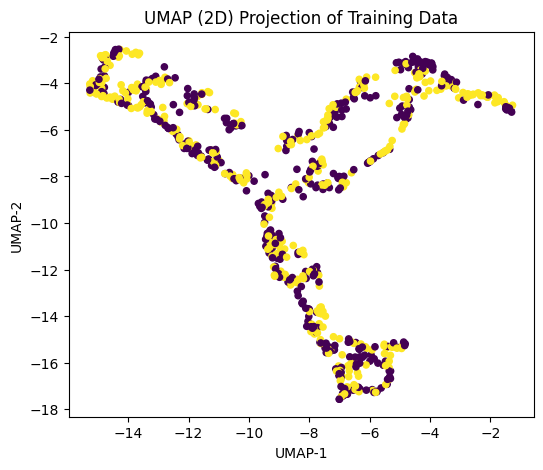

In [23]:
# Your code here
import umap

umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train)
X_test_umap  = umap_reducer.transform(X_test)

knn_umap = KNeighborsClassifier(n_neighbors=3)
knn_umap.fit(X_train_umap, y_train)
y_pred_umap = knn_umap.predict(X_test_umap)

print(f"UMAP (2D) Accuracy: {accuracy_score(y_test, y_pred_umap):.3f}")

plt.figure(figsize=(6,5))
plt.scatter(X_train_umap[:,0], X_train_umap[:,1], c=y_train, cmap="viridis", s=20)
plt.title("UMAP (2D) Projection of Training Data")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.show()


Explain your results in the cell below.  Which works better?  Why?

PCA (2D): Performs poorly because PCA is a linear projection that preserves global variance. The important class separation in this dataset happens along the z-axis (a small shift in mean), which is not captured well in the top 2 variance directions. As a result, the two classes overlap heavily in the projection.

UMAP (2D): Performs slightly better than PCA. UMAP is a nonlinear method that preserves local neighborhoods and can capture more structure. The embedding reveals some curved manifold structure, so the classes are a bit more separated, leading to better KNN accuracy compared to PCA. Still, performance is worse than in the full 3D space.

UMAP works better than PCA in low dimensions because it preserves local relationships and can reveal nonlinear separation. However, both methods underperform compared to the original data since reducing to 2D loses useful information. Dimensionality reduction is excellent for visualization, but too aggressive a reduction (like forcing to 2D) harms classification accuracy.